In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.colors as colors

cmap = cm.spring

In [107]:
w = 10
v0 = 0.1
x0 = v0/w

def path(t):
    return x0*np.sin(w*t), 0, v0*t

def path_deriv(t):
    return x0*w*np.cos(w*t), 0, v0

def rooter(tr, t, x, y, z):
    r = np.array([x,y,z])
    w = np.array(path(tr))
    return tr-t+np.sqrt(np.dot(r-w, r-w))

def rooter_slope(tr, t, x, y, z):
    r = np.array([x,y,z])
    w = np.array(path(tr))
    w_v = np.array(path_deriv(tr))

    numerator = np.dot(r-w, w_v)
    denominator = np.sqrt(np.dot(r-w, r-w))
    
    return 1 - numerator/denominator
    
    
def newtons_method(tr, t, x, y, z, N):
    for i in range(N):
        tr = tr - rooter(tr, t, x, y, z)/rooter_slope(tr, t, x, y, z)
    return tr


def elec_field_x(x, y, z, t):
    
    tr = newtons_method(t, t, x, y, z, 100)
    
    r = np.array([x,y,z])
    r_2 = np.dot(r,r)
    
    w = np.array(path(t))
    
    B = path_deriv(tr)
    B_2 = np.dot(np.array(path_deriv(tr)), np.array(path_deriv(tr)))
    r_dot_B = np.dot(r, B)
    
    numerator = (1-B_2)*(r[0]-w[0])
    denominator = (r_dot_B**2-B_2*r_2+(np.dot(r-w, r-w)))**(3/2)
    return numerator/denominator

def elec_field_y(x, y, z, t):
    
    tr = newtons_method(t, t, x, y, z, 100)
    
    r = np.array([x,y,z])
    r_2 = np.dot(r,r)
    
    w = np.array(path(t))
    
    B = path_deriv(tr)
    B_2 = np.dot(np.array(path_deriv(tr)), np.array(path_deriv(tr)))
    r_dot_B = np.dot(r, B)
    
    numerator = (1-B_2)*(r[1]-w[1])
    denominator = (r_dot_B**2-B_2*r_2+(np.dot(r-w, r-w)))**(3/2)
    return numerator/denominator

def elec_field_z(x, y, z, t):
    
    tr = newtons_method(t, t, x, y, z, 100)
    
    r = np.array([x,y,z])
    r_2 = np.dot(r,r)
    
    w = np.array(path(t))
    
    B = path_deriv(tr)
    B_2 = np.dot(np.array(path_deriv(tr)), np.array(path_deriv(tr)))
    r_dot_B = np.dot(r, B)
    
    numerator = (1-B_2)*(r[2]-w[2])
    denominator = (r_dot_B**2-B_2*r_2+(np.dot(r-w, r-w)))**(3/2)
    return numerator/denominator

def retarded_time_grid(t, X_d, Z_d):
    T_d = newtons_method(t, t, X_d, 0, Z_d, 100)
    return T_d

def elec_field_grid(X_d, Z_d, T_d):
    return elec_field(X_d, 0, Z_d, T_d)
    

In [104]:
np.dot((1, 2, 3), (4,5,6))

32

In [115]:
X_d, Z_d = np.meshgrid(np.arange(-1, 1, .1), np.arange(-1, 1 , .1))
T_d = retarded_time_grid(10, X_d, Z_d)

In [127]:
E_x = elec_field_x(X_d, 0, Z_d, 5)
E_y = elec_field_y(X_d, 0, Z_d, 5)
E_z = elec_field_z(X_d, 0, Z_d, 5)

/Users/lukepolson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in power
/Users/lukepolson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in power
/Users/lukepolson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in power


In [128]:
E_xx = E_x / np.sqrt(E_x**2+E_z**2)
E_zz = E_z / np.sqrt(E_x**2+E_z**2)

In [129]:
E_zz

array([[-8.32721946e-01, -8.58154445e-01, -8.82993437e-01,
        -9.06790026e-01, -9.29035992e-01, -9.49180203e-01,
        -9.66654606e-01, -9.80909244e-01, -9.91453626e-01,
        -9.97899496e-01, -9.99998470e-01, -9.97667821e-01,
        -9.90999352e-01, -9.80249555e-01, -9.65813063e-01,
        -9.48184564e-01, -9.27915954e-01, -9.05575199e-01,
        -8.81711739e-01, -8.56831009e-01],
       [-8.14454777e-01, -8.41895435e-01, -8.68943779e-01,
        -8.95097187e-01, -9.19767990e-01, -9.42299966e-01,
        -9.61998737e-01, -9.78176427e-01, -9.90207629e-01,
        -9.97589830e-01, -9.99998244e-01, -9.97324138e-01,
        -9.89688156e-01, -9.77425550e-01, -9.61046743e-01,
        -9.41181919e-01, -9.18520612e-01, -8.93756190e-01,
        -8.67541904e-01, -8.40461259e-01],
       [-7.93397207e-01, -8.22968760e-01, -8.52425317e-01,
        -8.81212431e-01, -9.08655907e-01, -9.33975738e-01,
        -9.56319900e-01, -9.74820475e-01, -9.88669662e-01,
        -9.97206385e-01, -9.9

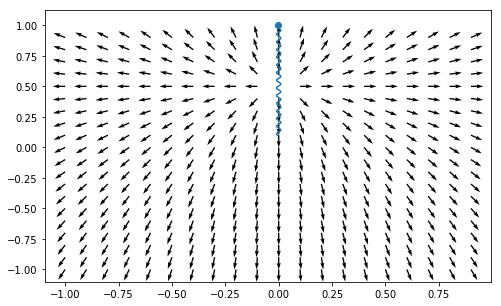

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

Q = ax.quiver(X_d, Z_d, E_xx, E_zz, units='width')
ax.plot(wx, wz)
ax.scatter(path(10)[0], path(10)[2])

In [65]:
x=1
y=1
z=1
t = 5
ttr = np.linspace(1, 10, 1000)

In [66]:
df = pd.DataFrame({'Time': ttr})
df['Position_Current'] = df['Time'].apply(lambda t: path(t))

In [67]:
wx, wy, wz = path(ttr)

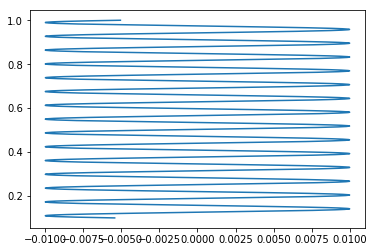

In [69]:
plt.plot(wx, wz)

In [20]:
ttr[np.argmin(np.abs(roo))]

3.6536536536536537